In [1]:
import os
import sys
from typing import Tuple, List

sys.path.append(os.path.join(os.getcwd(), "LightGlue"))
sys.path.append(os.path.join(os.getcwd(), "SuperGluePretrainedNetwork"))
sys.path.append(os.path.join(os.getcwd(), "omniglue"))
sys.path.append(os.path.join(os.getcwd(), "wildlife-tools"))

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import timm
import torchvision.transforms as T
from argparse import ArgumentParser
from tqdm import tqdm
from PIL import Image

from wildlife_datasets import analysis, datasets, loader, splits
from wildlife_tools.features import DeepFeatures
from wildlife_tools.data import WildlifeDataset 
from wildlife_tools.similarity import CosineSimilarity

from LightGlue.lightglue import LightGlue, SuperPoint, SIFT
from LightGlue.lightglue.utils import load_image, rbd
from LightGlue.lightglue import viz2d

from SuperGluePretrainedNetwork import match_pairs as SuperGlueMatching

# from omniglue import omniglue_extract as omniglue

import cv2


/opt/conda/envs/wildlife10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_dataset(dataset_name: str) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, str]:
    """
    Load dataset and split into training, validation, and test sets.

    Args:
        dataset_name (str): Name of the dataset.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, str]: DataFrames for training, validation, and test sets, and the dataset root directory.
    """
    if dataset_name == "LeopardID2022":
        d = datasets.LeopardID2022("datasets/LeopardID2022")
    elif dataset_name == "HyenaID2022":
        d = datasets.HyenaID2022("datasets/HyenaID2022")
    elif dataset_name == "ATRW":
        d = datasets.ATRW("datasets/ATRW")
    elif dataset_name == "WII":
        import wii_dataset
        d = wii_dataset.WII("datasets/WII")
    else:
        raise ValueError("Invalid dataset name")
    
    # remove those samples where an identity has fewer than 5 samples
    d.df = d.df.groupby("identity").filter(lambda x: len(x) >= 5)

    if dataset_name == "ATRW":
        df_train = d.df[d.df["original_split"] == "train"]
        df_test = d.df[d.df["original_split"] == "test"]
        df_val = df_test

    elif dataset_name == "WII":
        df_train = d.df[d.df["split"] == "train"]
        df_test = d.df[d.df["split"] == "test"]

        # remove those entries that dont have a flank column
        df_test = df_test.dropna(subset=["flank"])
        df_test = df_test.dropna(subset=["gallery_split"])

        df_val = df_test

    else:
        n_identites = len(d.df['identity'].unique())

        n_test_ids = int(np.ceil(0.33 * n_identites))
        n_val_ids = int(np.ceil(0.2 * (n_identites - n_test_ids)))

        splitter = splits.DisjointSetSplit(n_class_test=n_test_ids) # 64 test IDs = ceil(0.33 * 193)
        # splitter = splits.ClosedSetSplit(0.67)
        for idx_train, idx_test in splitter.split(d.df):
            _df_train, df_test = d.df.loc[idx_train], d.df.loc[idx_test]

        splitter_2 = splits.DisjointSetSplit(n_class_test=n_val_ids) # 26 val IDs = ceil(0.2 * 129)
        for idx_train, idx_val in splitter_2.split(_df_train):
            df_train, df_val = _df_train.loc[idx_train], _df_train.loc[idx_val]


    df_train = df_train.groupby("identity").filter(lambda x: len(x) >= 5)
    df_test = df_test.groupby("identity").filter(lambda x: len(x) >= 5)
    df_val = df_val.groupby("identity").filter(lambda x: len(x) >= 5)

    return df_train, df_val, df_test, d.root

In [3]:
def get_query_gallery_split(df: pd.DataFrame, root: str, transform: T.Compose, dataset_name: str) -> Tuple[WildlifeDataset, WildlifeDataset]:
    """
    Split dataset into query and gallery sets. For each identity, the first sample is used as the gallery image and the rest are used as query images.

    Args:
        df (pd.DataFrame): DataFrame containing dataset information.
        root (str): Root directory of the dataset.
        transform (T.Compose): Transformations to apply to the images.
        dataset_name (str): Name of the dataset.

    Returns:
        Tuple[WildlifeDataset, WildlifeDataset]: Query and gallery datasets.
    """

    if dataset_name == "WII":
        df_left = df[df["flank"] == "left"]
        df_right = df[df["flank"] == "right"]

        df_left_query = df_left[df_left["gallery_split"] == "query"]
        df_left_gallery = df_left[df_left["gallery_split"] == "gallery"]

        df_right_query = df_right[df_right["gallery_split"] == "query"]
        df_right_gallery = df_right[df_right["gallery_split"] == "gallery"]

        dataset_left_query = WildlifeDataset(df_left_query, root, transform=transform, img_load="bbox")
        dataset_left_gallery = WildlifeDataset(df_left_gallery, root, transform=transform, img_load="bbox")

        dataset_right_query = WildlifeDataset(df_right_query, root, transform=transform, img_load="bbox")
        dataset_right_gallery = WildlifeDataset(df_right_gallery, root, transform=transform, img_load="bbox")

        return dataset_left_query, dataset_left_gallery, dataset_right_query, dataset_right_gallery
    else:
        df_query = df.groupby("identity").apply(lambda x: x.iloc[1:])
        df_gallery = df.groupby("identity").apply(lambda x: x.iloc[:1])

    if dataset_name == "ATRW":
        dataset_query = WildlifeDataset(df_query, root, transform=transform)
        dataset_gallery = WildlifeDataset(df_gallery, root, transform=transform)
    else:    
        dataset_query = WildlifeDataset(df_query, root, transform=transform, img_load="bbox")
        dataset_gallery = WildlifeDataset(df_gallery, root, transform=transform, img_load="bbox")
    return dataset_query, dataset_gallery

In [4]:
def compute_metrics(preds: np.ndarray, gt: np.ndarray) -> None:
    """
    Compute top-1, top-3, and top-5 accuracy, precision, and recall.
    
    Args:
        preds (np.ndarray): (N, 5) Predictions.
        gt (np.ndarray): (N,) Ground truth.
    """

    # compute top-k accuracy
    top_1 = np.sum(preds[:, 0] == gt) / len(gt)
    top_3 = np.sum([gt[i] in preds[i, :3] for i in range(len(gt))]) / len(gt)
    top_5 = np.sum([gt[i] in preds[i, :] for i in range(len(gt))]) / len(gt)

    # compute precision and recall for k=1, 3, 5
    TP = np.sum( preds[:, 0] == gt )
    FP = np.sum( preds[:, 0] != gt )
    FN = len(gt) - TP
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)

    print("------k=1------")
    print(f"Top-1 Accuracy: {100*top_1:.2f}%")
    # print(f"Precision: {100*precision:.2f}%")
    # print(f"Recall: {100*recall:.2f}%")
    # print(F"TP: {TP}, FP: {FP}, FN: {FN}")
    print(f"Correct Matches: {TP}, Incorrect Matches: {FP}")

    # k = 3
    TP = np.sum([gt[i] in preds[i, :3] for i in range(len(gt))])
    FP = np.sum([gt[i] not in preds[i, :3] for i in range(len(gt))])
    FN = len(gt) - TP
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)

    print("------k=3------")
    print(f"Top-3 Accuracy: {100*top_3:.2f}%")
    # print(f"Precision: {100*precision:.2f}%")
    # print(f"Recall: {100*recall:.2f}%")
    # print(F"TP: {TP}, FP: {FP}, FN: {FN}")
    print(f"Correct Matches: {TP}, Incorrect Matches: {FP}")

    # k = 5
    TP = np.sum([gt[i] in preds[i, :] for i in range(len(gt))])
    FP = np.sum([gt[i] not in preds[i, :] for i in range(len(gt))])
    FN = len(gt) - TP
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)

    print("------k=5------")
    print(f"Top-5 Accuracy: {100*top_5:.2f}%")
    # print(f"Precision: {100*precision:.2f}%")
    # print(f"Recall: {100*recall:.2f}%")
    # print(f"TP: {TP}, FP: {FP}, FN: {FN}")
    print(f"Correct Matches: {TP}, Incorrect Matches: {FP}")

In [5]:
DATASET = "WII"
detector = "arcface"
matcher =  "arcface"

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
df_train, df_val, df_test, root = get_dataset(DATASET)

if matcher == "arcface" or detector == "arcface":
    transforms = T.Compose([
        T.Resize([112, 112], antialias=True),
        T.ToTensor(),
        T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
else:
    transforms = T.Compose([
        T.Resize([384, 384]),
        T.ToTensor(),
        T.Normalize(
            mean=[0.5, 0.5, 0.5],
            std=[0.5, 0.5, 0.5]
        )
    ])

In [7]:
print(f"Number of training samples: {len(df_train)}")
print(f"Number of validation samples: {len(df_val)}")
print(f"Number of test samples: {len(df_test)}")
left_query, left_gallery, right_query, right_gallery = get_query_gallery_split(df_val, root, transforms, dataset_name=DATASET)
print(f"Number of left query samples: {len(left_query)}")
print(f"Number of left gallery samples: {len(left_gallery)}")
print(f"Number of right query samples: {len(right_query)}")
print(f"Number of right gallery samples: {len(right_gallery)}")

Number of training samples: 3405
Number of validation samples: 3498
Number of test samples: 3498
Number of left query samples: 1233
Number of left gallery samples: 465
Number of right query samples: 1334
Number of right gallery samples: 466


In [8]:
sys.path.append(os.path.join(os.getcwd(), "insightface/recognition/arcface_torch/"))
from backbones import get_model

weights_path = "/home/atharv21027/ReID-with-graphs/insightface/recognition/arcface_torch/work_dirs/ms1mv3_r50_onegpu/model.pt"
arcface = get_model("r50", fp16=False)
arcface.load_state_dict(torch.load(weights_path))
arcface = arcface.eval().to(device)

In [11]:
preds_path = f"outputs/{matcher}/{DATASET}/{detector}_preds.npy"
if os.path.exists(preds_path):
    PREDS = np.load(preds_path)
    GT = np.load(f"outputs/{matcher}/{DATASET}/{detector}_gt.npy")
    compute_metrics(PREDS, GT)

------k=1------
Top-1 Accuracy: 3.31%
Precision: 3.31%
Recall: 3.31%
TP: 122, FP: 3567, FN: 3567
------k=3------
Top-3 Accuracy: 7.37%
Precision: 7.37%
Recall: 7.37%
TP: 272, FP: 3417, FN: 3417
------k=5------
Top-5 Accuracy: 10.84%
Precision: 10.84%
Recall: 10.84%
TP: 400, FP: 3289, FN: 3289


In [9]:
# for each gallery image, compute the arcface feature embedding and store in a tensor
gallery_features_left = []
gallery_labels_left = []

gallery_features_right = []
gallery_labels_right = []

for i in tqdm(range(len(left_gallery))):
    img, label = left_gallery[i]
    img = img.unsqueeze(0).to(device)
    with torch.no_grad():
        feature = arcface(img)

    gallery_features_left.append(feature)
    gallery_labels_left.append(label)
    
for i in tqdm(range(len(right_gallery))):
    img, label = right_gallery[i]
    img = img.unsqueeze(0).to(device)
    with torch.no_grad():
        feature = arcface(img)

    gallery_features_right.append(feature)
    gallery_labels_right.append(label)

100%|██████████| 466/466 [00:58<00:00,  7.97it/s]


In [41]:
# write a function to display the k-th left flank image and the k-th right flank image
def display_flank_images(k: int, flank: str):
    # get the k-th left flank
    # img, label, flank = dataset_gallery[k]
    i = -1
    for j in range(len(dataset_gallery)):
        if dataset_gallery[j][2] == flank:
            if i == k:
                img, label, flank = dataset_gallery[j]
                break
            i += 1

    img = img.permute(1, 2, 0).numpy()

    img = (img + 1) / 2

    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f"Flank: {flank}")

    plt.show()

In [10]:
gallery_features_left = torch.cat(gallery_features_left, dim=0)
gallery_labels_left = np.array(gallery_labels_left)

gallery_features_right = torch.cat(gallery_features_right, dim=0)
gallery_labels_right = np.array(gallery_labels_right)

In [11]:
gallery_labels_left.shape

(465,)

In [14]:
PREDS[:10]

array([[  7., 106.,  96.,  16.,   9.],
       [106.,  48.,  29.,  18.,  41.],
       [  8.,  46.,  30.,  91.,  18.],
       [  5.,   6.,  38.,  40.,  69.],
       [ 18.,  80.,  94.,   6.,  89.],
       [106.,  18.,  41., 111.,  85.],
       [ 31.,  91.,  29.,  65.,  93.],
       [106.,  85.,  41.,  22.,  40.],
       [ 45.,  35.,  36.,  60.,  52.],
       [101.,  30.,   1., 102.,  33.]])

In [12]:
for i in range(10):
    img, label, flank = dataset_query[i]
    img = img.unsqueeze(0).to(device)
    with torch.no_grad():
        query_feature = arcface(img)
    sims = []
    if flank == "left":
        for gallery_embedding in gallery_features_left:
            similarity = torch.nn.functional.cosine_similarity(query_feature, gallery_embedding, dim=1)
            sims.append(similarity.item())
    else:
        for gallery_embedding in gallery_features_right:
            similarity = torch.nn.functional.cosine_similarity(query_feature, gallery_embedding, dim=1)
            sims.append(similarity.item())

    sims = np.array(sims)
    if flank == "left":
        preds = gallery_labels_left[np.argsort(sims)[::-1]]
    else:
        preds = gallery_labels_right[np.argsort(sims)[::-1]]
    conf_scores = np.sort(sims)[::-1]

    print(f"Top 5 IDs: {preds[:5]}")
    print(f"cosine_sim: {conf_scores[:5]}")
    print(f"GT identity: {label}")
    if flank == "left":
        print(f"Similarity with GT: {sims[gallery_labels_left == label]}")
    else:
        print(f"Similarity with GT: {sims[gallery_labels_right == label]}")
    print(f"Rank of GT: {np.where(preds == label)[0][0] + 1}\n")

Top 5 IDs: [5 2 5 3 0]
cosine_sim: [0.29266334 0.24509577 0.21961318 0.20123601 0.18193996]
GT identity: 0
Similarity with GT: [ 0.0338765   0.18193996  0.17619103  0.04043058  0.04296661 -0.02329883
  0.07604212]
Rank of GT: 5

Top 5 IDs: [0 4 2 2 1]
cosine_sim: [0.98898351 0.38243145 0.25843188 0.24266416 0.23342259]
GT identity: 0
Similarity with GT: [0.11591181 0.09668694 0.06794575 0.98898351 0.04454111 0.19366111
 0.05157034]
Rank of GT: 1

Top 5 IDs: [1 9 1 2 2]
cosine_sim: [0.35755527 0.31526726 0.26537636 0.26273939 0.25450784]
GT identity: 0
Similarity with GT: [0.00367009 0.05236271 0.05921794 0.04435608 0.10549391 0.03223525
 0.24935833]
Rank of GT: 6

Top 5 IDs: [0 4 5 1 0]
cosine_sim: [0.28778327 0.1923418  0.18405065 0.17496753 0.16967586]
GT identity: 0
Similarity with GT: [0.07024509 0.03182238 0.03385666 0.16967586 0.03156309 0.28778327
 0.05238901]
Rank of GT: 1

Top 5 IDs: [0 0 0 1 8]
cosine_sim: [0.31781119 0.28979743 0.22825173 0.22411242 0.21596216]
GT identity: 

In [12]:
%matplotlib inline

In [22]:
def display_img(img: torch.Tensor) -> None:
    """
    Display an image tensor using PIL.

    Args:
        img (torch.Tensor): Image tensor.
    """
    img = img.permute(1, 2, 0).cpu().numpy()
    img = (img + 1) / 2
    img = (img * 255).astype(np.uint8)
    img = Image.fromarray(img)
    img.show()

def display_top_preds(i):
    flank = "right"
    if flank == "left":
        img, label = left_query[i]
        img = img.unsqueeze(0).to(device)
        with torch.no_grad():
            query_feature = arcface(img)
        sims = []
        for gallery_embedding in gallery_features_left:
            similarity = torch.nn.functional.cosine_similarity(query_feature, gallery_embedding, dim=1)
            sims.append(similarity.item())
    else:
        img, label = right_query[i]
        img = img.unsqueeze(0).to(device)
        with torch.no_grad():
            query_feature = arcface(img)
        sims = []
        for gallery_embedding in gallery_features_right:
            similarity = torch.nn.functional.cosine_similarity(query_feature, gallery_embedding, dim=1)
            sims.append(similarity.item())


    sims = np.array(sims)
    sort_indices = np.argsort(sims)[::-1]
    if flank == "left":
        preds = gallery_labels_left[sort_indices]
        gt_scores = sims[gallery_labels_left == label]
    else:
        preds = gallery_labels_right[sort_indices]
        gt_scores = sims[gallery_labels_right == label]
    conf_scores = sims[sort_indices]

    np.where(preds == label)[0][0] + 1

    # display three rows. First row has the image, second row has the images corresponding to top-5 predictions with similarity score as text caption, and the third row has the GT identity and similarity score
    img = img.squeeze(0).permute(1, 2, 0).cpu().numpy()
    img = (img + 1) / 2
    img = (img * 255).astype(np.uint8)

    fig1, ax1 = plt.subplots(1, 1, figsize=(3, 3))
    ax1.imshow(img)
    ax1.axis("off")
    ax1.set_title("Query Image")

    if flank == "left":
        # Get all gallery images with the same identity as the GT
        gallery_flank_imgs = []
        gallery_GT_imgs = []
        for j in range(len(left_gallery)):
            # if dataset_gallery[j][2] == flank:
            gallery_flank_imgs.append(left_gallery[j][0])
            if (left_gallery[j][1] == label):
                gallery_GT_imgs.append(left_gallery[j][0])
    else:
        gallery_flank_imgs = []
        gallery_GT_imgs = []
        for j in range(len(right_gallery)):
            # if dataset_gallery[j][2] == flank:
            gallery_flank_imgs.append(right_gallery[j][0])
            if (right_gallery[j][1] == label):
                gallery_GT_imgs.append(right_gallery[j][0])

    gallery_flank_imgs = torch.stack(gallery_flank_imgs, dim=0)
    gallery_GT_imgs = torch.stack(gallery_GT_imgs, dim=0)

    gallery_flank_imgs = gallery_flank_imgs[sort_indices.copy()]

    # Second graph: Display top-5 predictions
    fig2, axs2 = plt.subplots(1, 5, figsize=(20, 5))
    for j in range(5):
        pred_img = gallery_flank_imgs[j].permute(1, 2, 0).cpu().numpy()
        pred_img = (pred_img + 1) / 2
        pred_img = (pred_img * 255).astype(np.uint8)
        axs2[j].imshow(pred_img)
        axs2[j].axis("off")
        axs2[j].set_title(f"ID: {preds[j]}\nSim: {conf_scores[j]:.2f}")

    # Third graph: Display ground truth identity

    fig3, axs3 = plt.subplots(1, len(gallery_GT_imgs), figsize=(20, 5))
    for j in range(len(gallery_GT_imgs)):
        pred_img = gallery_GT_imgs[j].permute(1, 2, 0).cpu().numpy()
        pred_img = (pred_img + 1) / 2
        pred_img = (pred_img * 255).astype(np.uint8)
        axs3[j].imshow(pred_img)
        axs3[j].axis("off")
        axs3[j].set_title(f"GT: {label}\nSim: {gt_scores[j]:.2f}")


    # fig3, ax3 = plt.subplots(1, 1, figsize=(3, 3))
    # gt_img = dataset_gallery[label][0].permute(1, 2, 0).cpu().numpy()
    # gt_img = (gt_img + 1) / 2
    # gt_img = (gt_img * 255).astype(np.uint8)
    # ax3.imshow(gt_img)
    # ax3.axis("off")
    # ax3.set_title(f"GT ID: {label}\nSim: {gt_score[0]:.2f}")

    # print(f"Top 5 IDs: {preds[:5]}")
    # print(f"cosine_sim: {conf_scores[:5]}")
    # print(f"GT identity: {label}")
    # if flank == "left":
    #     print(f"Similarity with GT: {sims[gallery_labels_left == label]}")
    # else:
    #     print(f"Similarity with GT: {sims[gallery_labels_right == label]}")
    print(f"Rank of GT: {np.where(preds == label)[0][0] + 1}\n")
    print("---------------------------------------------------")

    plt.show()
    

In [15]:
# dataset_query.metadata.iloc[2]
# display_flank_images(57, "left")
len(gallery_labels_left)

465

Rank of GT: 66

---------------------------------------------------


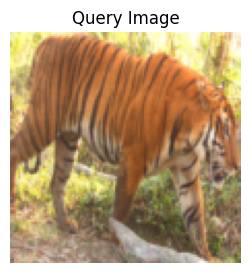

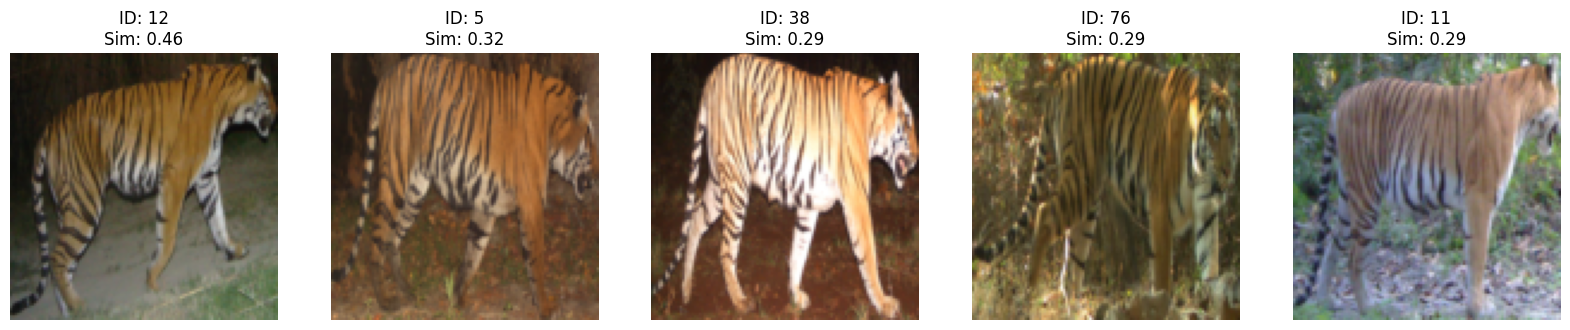

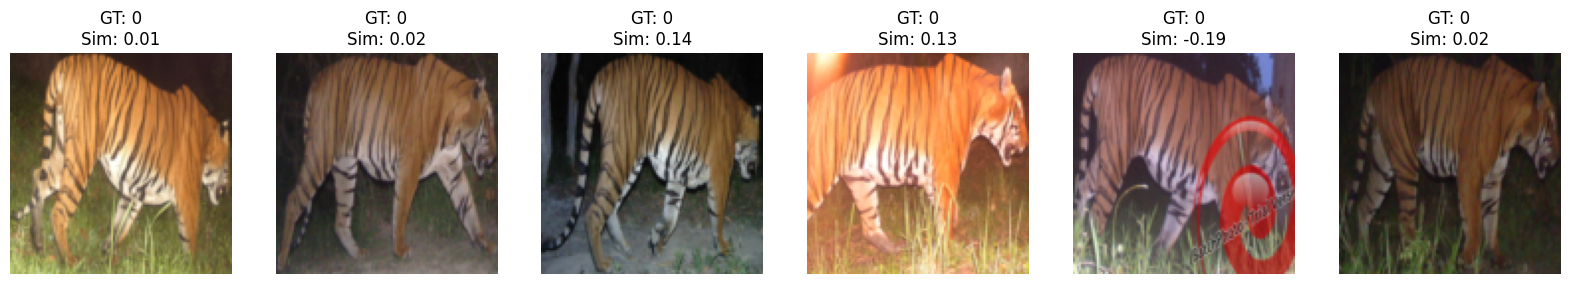

In [25]:
# display_img(dataset_query[8][0])
# display_img(dataset_gallery[1][0])
display_top_preds(2)

In [68]:
# Get all feature embeddings of every image in the dataset. Make a t-SNE plot of the embeddings color-coded by identity.

# for each image in the dataset, compute the arcface feature embedding and store in a tensor
all_features = []
all_labels = []
for i in tqdm(range(len(dataset_gallery))):
    img, label = dataset_gallery[i]
    img = img.unsqueeze(0).to(device)
    with torch.no_grad():
        feature = arcface(img)
    all_features.append(feature)
    all_labels.append(label)

for i in tqdm(range(len(dataset_query))):
    img, label = dataset_query[i]
    img = img.unsqueeze(0).to(device)
    with torch.no_grad():
        feature = arcface(img)
    all_features.append(feature)
    all_labels.append(label)

all_features = torch.cat(all_features, dim=0)
all_labels = np.array(all_labels)


100%|██████████| 115/115 [00:04<00:00, 24.63it/s]


In [69]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_features = tsne.fit_transform(all_features.cpu().numpy())


/opt/conda/envs/py10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


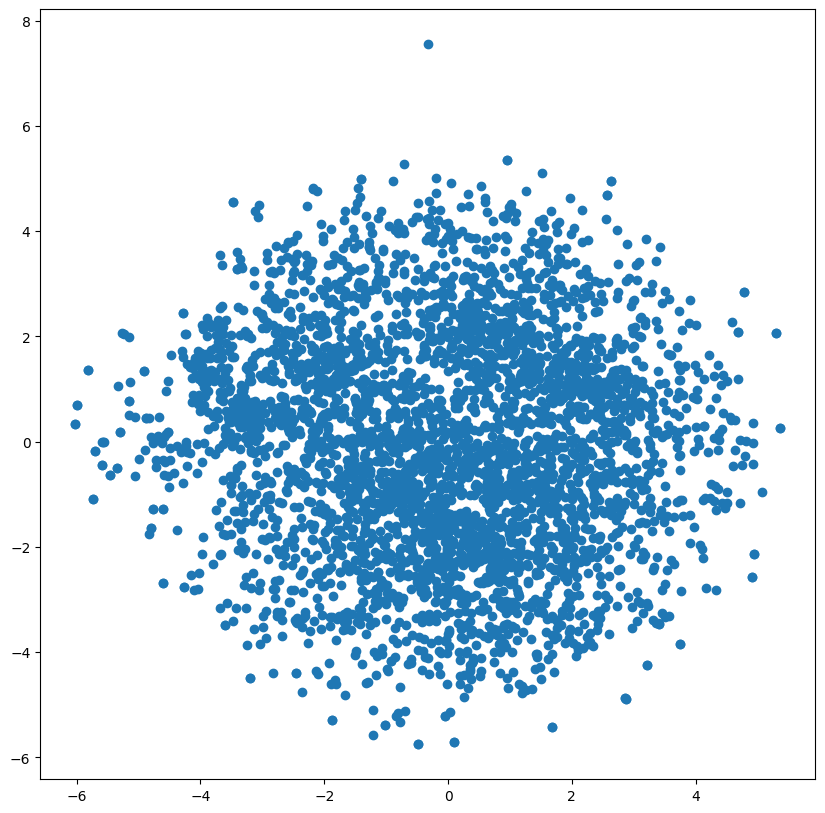

In [72]:
# # Create a color map based on the unique labels
# unique_labels = np.unique(all_labels)
# colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))
# label_to_color = {label: colors[i] for i, label in enumerate(unique_labels)}

# # Plot t-SNE embeddings
# plt.figure(figsize=(10, 10))
# for label in unique_labels:
#     indices = all_labels == label
#     plt.scatter(tsne_features[indices, 0], tsne_features[indices, 1], color=label_to_color[label], label=label, s=10)

# plt.legend(title="Identity")
# plt.title("t-SNE plot of feature embeddings color-coded by identity")
# plt.xlabel("t-SNE feature 1")
# plt.ylabel("t-SNE feature 2")
# plt.show()

plt.figure(figsize=(10, 10))
for i in range(len(all_labels)):
    plt.scatter(tsne_features[i, 0], tsne_features[i, 1], c=all_labels[i], cmap="tab20")
    